# Event-driven machine learning focusing on feature selection

The **PdM(Predictive Maintenance)** approach proposed in [14], although it is evaluated over a use case
of automated teller machines (**ATMs**), is **general enough to be applied on any
industrial scenario**, where error and failure logs are available. It follows a similar
rationale as [10], but implicitly assumes that the **log types recorded are more
commonly related to the targeted failure** (e.g., generated from software exceptions) and puts more **emphasis on feature generation and selection**. We will refer
to this approach as **FSPdM**. Its main drawback is that it **cannot scale in the
number of event types** that are present in the logs.

The authors propose a configurable approach for the creation of the training
and testing datasets and the formation of a binary classification problem. More
specifically, the dataset is divided into partitions (named **Observation Windows
(OW)**) and each OW is further divided into **daily segments**. Every OW, is fol-
lowed by a **Prediction Window (PW)** (i.e. partition with daily segments), in
which a fault is predicted to take place. The range from the beginning of each
OW up to the end of the related PW defines a **training or testing instance**. The
**labelling of an instance (i.e. classes: likely to fail, or not to fail)** depends on the
existence of a ticket report inside the PW (i.e. if there is a ticket in the PW, the
instance is considered positive (i.e. likely to fail)).




10.Korvesis, P., Besseau, S., Vazirgiannis, M.: Predictive maintenance in aviation:
Failure prediction from post 
ight reports. In: IEEE Int. Conf. on Data Engineering
(ICDE). pp. 1414{1422 (2018)

14.Wang, J., Li, C., Han, S., Sarkar, S., Zhou, X.: Predictive maintenance based on
event-log analysis: A case study. IBM Journal of Research and Development 61(1),
11{121 (2017)

### Setup

In [1]:
#Make the necessary imports.

suppressMessages(library(CORElearn))
suppressMessages(library(dplyr))
suppressMessages(library(plyr))
suppressMessages(library(data.table))
suppressMessages(library(randomForest))
suppressMessages(library(ggplot2))
suppressMessages(library(grid))
suppressMessages(library(argparser))
suppressMessages(library(arules))
suppressMessages(library(arulesSequences))
suppressMessages(library(xgboost))
suppressMessages(library(DiagrammeR))

Warning message:
"package 'CORElearn' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"Warning message:
"package 'plyr' was built under R version 3.6.2"Warning message:
"package 'data.table' was built under R version 3.6.2"Warning message:
"package 'randomForest' was built under R version 3.6.2"Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'argparser' was built under R version 3.6.2"Warning message:
"package 'arules' was built under R version 3.6.3"Warning message:
"package 'arulesSequences' was built under R version 3.6.3"Warning message:
"package 'xgboost' was built under R version 3.6.3"Warning message:
"package 'DiagrammeR' was built under R version 3.6.3"

### Init variables

In [2]:
#Make an argument parser named p and keep there the necessary variables.

p <- arg_parser("Implementation of the IBMs ATM Predictor")

# Add a positional argument
p <- add_argument(p, "train", help="training dataset")
p <- add_argument(p, "test", help="test dataset")

p <- add_argument(p, "fet", help="different types of the fault events",default=11)
p <- add_argument(p, "tet", help="type of the target fault events",default=11)

p <- add_argument(p, "--X", help="# of segments/sub-windows", default=3)#3#1
p <- add_argument(p, "--M", help="segment legth (in days)", default=2)#2#1
p <- add_argument(p, "--Y", help="length of the prediction window (in days)", default=3)#3#2
p <- add_argument(p, "--Z", help="length of the buffer window (in days)", default=0)
p <- add_argument(p, "--N", help="moving step (in days)", default=2)#2#1
p <- add_argument(p, "--step", help="feature selection decrease step", default=5)#5#1

p <- add_argument(p, "--sup", help="pattern features appriori support", default=0.8)
p <- add_argument(p, "--conf", help="pattern features confidence", default=0.6)
p <- add_argument(p, "--fs", help="apply feature selection", default=TRUE)
p <- add_argument(p, "--pf", help="use pattern features", default=TRUE)#FALSE
p <- add_argument(p, "--sf", help="use similarity feature", default=TRUE)
p <- add_argument(p, "--plogic", help="TRUE for custom pattern detection logic FALSE for paper's logic", default=TRUE)
p <- add_argument(p, "--csv", help="output for csv", default=FALSE)
p <- add_argument(p, "--minwint", help="min # of days before failure to expect a warning for true positive decision", default=2)#2#3
p <- add_argument(p, "--maxwint", help="max # of days before failure to expect a warning for true positive decision", default=5)



### Define the necessary variables

In [1]:
#Define the necessary variables.

argv = data.frame() #make a data frame named argv
#if( length(commandArgs(trailingOnly = TRUE)) != 0){
if(FALSE){
  argv <- parse_args(p)
} else {
  #parse to argv the p's arguments as  argv <- parse_args(p,c("training dataset's path","test dataset's path",fet,tet))  
  argv <- parse_args(p,c("C:/Users/Public/ptyxiakh/training_my_dataset2.csv","C:/Users/Public/ptyxiakh/testing_my_dataset2.csv",11,11))
}

#init the variables
train_path=argv$train
test_path=argv$test

b_length = argv$fet
target_event = argv$tet

X = argv$X
M = argv$M
Y = argv$Y
Z = argv$Z
N = argv$N
step = argv$step
sup = argv$sup
conf = argv$conf
FEATURE_SELECTION = argv$fs
PATTERN_FEATURES = argv$pf
JACCARD_FEATURE = argv$sf
PATTERN_CUSTOM = argv$plogic
csv = argv$csv
max_warning_interval = argv$maxwint
min_warning_interval = argv$minwint

print("The data frame argv is:")
print(argv)

NULL

ERROR: Error in parse_args(p, c("C:/Users/Public/ptyxiakh/training_my_dataset.csv", : could not find function "parse_args"


### Reading function
**function: read_dataset**

In [4]:
#Function for reading the csv file and save it to a two column table.

read_dataset <- function(path){
  dataset = read.table(path, header = TRUE, sep = ",", dec = ".", comment.char = "#")
  dataset[, 2]  <- as.numeric(dataset[, 2])
  return(dataset)
}

### Read train and test set

The recorded log types read from csv files.
One csv file(at **train_path**) has the **training_set** and the other(at **test_path**) the **testing_set**.

In [5]:
#Reading train and test set.

training_set = read_dataset(train_path)
test_set =  read_dataset(test_path)

print("The test_set and training_set looks like:")
print(head(test_set))

[1] "The test_set and training_set looks like:"
  Timestamps Event_id
1 2014-01-21        1
2 2014-01-21        3
3 2014-01-21        4
4 2014-01-21        5
5 2014-01-21        6
6 2014-01-21        4


### Functions for computing frequencies of events
**1) function: create_episodes_list**

In [6]:
#Function for creating frequency vectors for each day.

create_episodes_list <- function(ds2years,b_length){

  #data.frame for episodes
  episode_df <- data.frame(Timestamps=as.Date(character()),Event_id=integer())
  
  #Change ds2years(table) to episode_df(data frame)    
    
  #iterate over every line of the original dataset
  for(i in 1:nrow(ds2years)) {
    #get the current row of ds2years(table of data set)
    meas <- ds2years[i,]
    #add it to data frame  
    episode_df <- rbind(episode_df,data.frame(Timestamps=meas$Timestamps, Event_id=meas$Event_id))

  }
  #group by day
  aggr_episode_df = aggregate(episode_df[ ,2], FUN=function(x){return(x)}, by=list(as.Date(episode_df$Timestamps, "%Y-%m-%d")))
  
  #binarize the frequncy vector(function: compute_frequency_vectors)
  frequency_day_vectors = compute_frequency_vectors(aggr_episode_df,b_length)

  return(frequency_day_vectors)
}

**2) function: compute_frequency_vectors**

In [7]:
#Convert event vectors to binary vectors

compute_frequency_vectors <- function(aggr_episode_df,b_length){
    
  #data frame for binary frequency vectors  
  freq_aggr_episode_df <- data.frame(matrix(ncol = b_length+1, nrow = 0))
  
  #x keeps the names of the columns. |Timestamps||e_1||e_2|...|e_b_length|  
  x <- c(c("Timestamps"), c(paste("e_",c(1:b_length),sep = "")))

  #iterate over every line(day) of the aggr_episode_df
  for(i in 1:nrow(aggr_episode_df)) {
      
      #init a vector with b_length zeros
      freq_vector = as.vector(integer(b_length))
    
      #get the current row of aggr_episode_df(frequency vector-data frame of data set)
      seg <- aggr_episode_df[i,]
    
      #for every value(fault event) in the current line(that happened in the current day)
      for(value in seg$x[[1]]){
          #replace the 0 in freq_vector with 1 at "value=fault event" position 
          freq_vector[[value]] = length(which(seg$x[[1]] == value))
      }
    
      #add a new line to the bin_aggr_epissode_df
      #we use a matrix holding the elements of the new_data.frame as matrix is able to store variable of different data types
      
      date = as.Date(seg$Group.1[[1]])
      new_df = data.frame(matrix(c(date, freq_vector),nrow=1,ncol=b_length+1))
      freq_aggr_episode_df <- rbind(freq_aggr_episode_df,new_df)
  }
  #set column's name as x defines
  colnames(freq_aggr_episode_df) <- x
  
  #set column "Timestamps" x to a Date: "Y-m-d" column  
  freq_aggr_episode_df$Timestamps <- as.Date(freq_aggr_episode_df$Timestamps , origin="1970-01-01")
    
  return(freq_aggr_episode_df)
}

In [8]:
#Create for each of the training and  testing set a dataframe keeping for each day the frequency of the fault events.

frequency_day_vectors = create_episodes_list(training_set,b_length)
test_frequency_day_vectors = create_episodes_list(test_set,b_length)

print("For training set head of frequency_day_vectors is:")
print(head(frequency_day_vectors))

[1] "For training set head of frequency_day_vectors is:"
  Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11
1 2014-01-01   0   0   0   0   0   0   0   0   0    0    1
2 2014-01-02   0   1   1   1   1   1   1   0   0    0    0
3 2014-01-03   1   1   1   1   1   2   1   2   0    0    0
4 2014-01-04   0   0   1   1   2   1   0   1   0    0    0
5 2014-01-05   1   1   1   1   1   2   2   0   0    0    0
6 2014-01-06   1   1   1   1   1   0   0   1   0    1    0


### OW and PW
For the testing dataset (**test_frequency_day_vectors**) OW and PW are presented.

In [26]:
 for(i in  seq(1,nrow(test_frequency_day_vectors), by=N)){
      
    #if the end of PW is equal to the total days then stop
    if((i-1+X*M+Z+Y-1) > nrow(test_frequency_day_vectors)){
      break
    }
    
    #take a window of X*M=6 days, [1:6] [3:8] [5:10] ... [11 16]
    #subset by row, get the X*M days
    OW = test_frequency_day_vectors[i:((X*M)+(i-1)),] 
    #subset by row, get the Y days
    PW = test_frequency_day_vectors[(i-1+X*M+Z):(i-1+X*M+Z+Y-1),]
    
    print("For OW:")
    print(OW)
    print("")
    print("the PW is:")
    print(PW) 
    print("-----------------------------------------------------")
     
}     

[1] "For OW:"
  Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11
1 2014-01-21   1   0   1   2   1   1   2   0   0    0    0
2 2014-01-22   1   1   1   1   2   0   1   0   0    0    0
3 2014-01-23   1   1   1   1   1   2   0   1   0    0    0
4 2014-01-24   0   0   1   1   2   0   1   0   0    1    0
5 2014-01-25   1   1   2   1   1   2   1   0   1    0    0
6 2014-01-26   1   1   0   1   1   1   2   0   0    0    1
[1] ""
[1] "the PW is:"
  Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11
6 2014-01-26   1   1   0   1   1   1   2   0   0    0    1
7 2014-01-27   0   1   2   1   1   1   1   0   1    0    0
8 2014-01-28   1   1   1   1   1   0   1   0   0    1    0
[1] "-----------------------------------------------------"
[1] "For OW:"
  Timestamps e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11
3 2014-01-23   1   1   1   1   1   2   0   1   0    0    0
4 2014-01-24   0   0   1   1   2   0   1   0   0    1    0
5 2014-01-25   1   1   2   1   1   2   1   0   1    0    0
6 2

## Functions for creating new instances for the dataset
Each created instance is comprised by five feature categories: 

- **Basic Features**: A frequency vector for each error type inside an OW. 

- **Advanced Statistical Features**: A vector of statistics like, minimum, maximum and mean distance of an error type inside the OW, from the beginning of the corresponding PW and mean and standard deviation of the distance between instances of the same error type inside the OW, for each error type. 

- **Pattern-based Features**: A binary vector of error type patterns, which is created based on a confidence threshold on the relative frequency of each pattern in all the OWs. The initial set of patterns is created based on the power set (excluding the null set) of the error types inside each OW. 

- **Failure Similarity Features**: The Jaccard similarity of two consecutive failures (tickets) of the same type, computed based onthe error types of each corresponding OW. 

- **Profile-based Features**: Consider equipment specific features, like the model and the installation date of a ATM machine.






**1) function: create_instances**

In [9]:
#Function that creates new instances(for a dataset) from frequency vector.

create_instances <- function(frequency_day_vectors,target_event,X,M,Y,Z,N,PATTERN_FEATURES,SIMILARITY_FEATURE,test,conf,sup){
  
  #frequency_day_vectors withoult column timestamps  
  frequency_day_vectors = frequency_day_vectors[ , !(names(frequency_day_vectors) %in% c("Timestamps"))]

  #init data frame instances_df(function: init)  
  instances_df = init(frequency_day_vectors,target_event,X,M,Y,Z,N,PATTERN_FEATURES,SIMILARITY_FEATURE,test,conf,sup);

  #for each OW
  for(i in  seq(1,nrow(frequency_day_vectors), by=N)){
      
    #if the end of PW is equal to the total days then stop
    if((i-1+X*M+Z+Y-1) > nrow(frequency_day_vectors)){
      break
    }
    
    #take a window of X*M=6 days, [1:6] [3:8] [5:10] ... [11 16]
    #subset by row, get the X*M days
    OW = frequency_day_vectors[i:((X*M)+(i-1)),]  

    #compute the new instances of each OW   
    instance = compute_pattern_features(PATTERN_FEATURES,OW)
    instance = c(instance,compute_similarity_feature(SIMILARITY_FEATURE,OW))
    instance = c(instance,compute_advanced_statistic_features(OW))
    instance = compute_basic_statistic_features(instance,OW)
      
    #save it as a new data frame row 
    instance_df = as.data.frame(instance)

    #check the label of the OW
    Label = label_OW(i,frequency_day_vectors,target_event,X,M,Y,Z,N,test)
    
    #if a buffer window is used and target event is happened in it    
    if(is.null(Label)){
      if(!csv){
        print("moving to the next")
      }
      next
    }
    
    #set label of instance_df to Label    
    instance_df$Label = Label
    
    #set instance_df as a new row of instances_df data frame  
    instances_df = rbind(instances_df,instance_df) 
  }
    
  return(instances_df)
}

**2) function: init**

In [10]:
#Function that inits the instances data frame.

init <- function(frequency_day_vectors,target_event,X,M,Y,Z,N,PATTERN_FEATURES,SIMILARITY_FEATURE,test,conf,sup){
  
  #make a data frame named instances_df with ncol=(5+ #of sub-windows)*(# of frequency_day_vectors' columns)+1
  #                                     and  nrow=0
  instances_df = data.frame(matrix(ncol = (ncol(frequency_day_vectors)*5+ncol(frequency_day_vectors)*X+1), nrow = 0))
  
  #if we chose to get pattern features
  #---------------------------------------------------------------------------------------------------  
  if(PATTERN_FEATURES && SIMILARITY_FEATURE){
    if(!test){
      #get the frequent patterns(function: getFrequentPatterns)  
      freq_pattern_items <<- getFrequentPatterns(frequency_day_vectors,target_event,X,M,Y,Z,N,conf,sup)
    }
    #increase the instances_df column size by the length of the patterns + 1(for similarity feature) 
    instances_df = data.frame(matrix(ncol = (ncol(frequency_day_vectors)*5+ncol(frequency_day_vectors)*X+length(freq_pattern_items)+1+1), nrow = 0))
  } else if(PATTERN_FEATURES){
    if(!test){
      #get the frequent patterns(function: getFrequentPatterns)   
      freq_pattern_items <<- getFrequentPatterns(frequency_day_vectors,target_event,X,M,Y,Z,N,conf,sup)
    }
    #increase the instances_df column size by the length of the patterns  
    instances_df = data.frame(matrix(ncol = (ncol(frequency_day_vectors)*5+ncol(frequency_day_vectors)*X+length(freq_pattern_items)+1), nrow = 0))
  #--------------------------------------------------------------------------------------------------- 
  
  #if we did not choose to get pattern features, but we chose similarity feature
  #---------------------------------------------------------------------------------------------------     
  } else if(SIMILARITY_FEATURE){
    #increase the instances_df column size by 1(for similarity feature)
    instances_df = data.frame(matrix(ncol = (ncol(frequency_day_vectors)*5+ncol(frequency_day_vectors)*X+1+1), nrow = 0))
  }
  #---------------------------------------------------------------------------------------------------  
  
  #if it is not for a test dataset and we chose similarity feature    
  if(!test && SIMILARITY_FEATURE){
    #get the first positive Observed Window(function: get_first_positive_OW)  
    first_positive_OW <<- get_first_positive_OW(frequency_day_vectors,target_event,X,M,Y,Z,N,test)
    
    print("First_positive OW is:")
    print(first_positive_OW)  
    print("")    
  }
  
  if(PATTERN_FEATURES && length(freq_pattern_items) <= 0){
    if(!csv){
      print("WARNING: No patterns found.")
      print("")
    }
  }
  
  return(instances_df)
}

### 3) Functions for exporting patterns using frequency
**3a) function: getFrequentPatterns**

**3b) function: getFrequentPatternsPaperConf**

**3c) function: getFrequentPatternsCustom**

In [11]:
#Functions used for export frequent patterns.

#For calling the appropriate function 
getFrequentPatterns <- function(frequency_day_vectors,target_event,X,M,Y,Z,N,conf_level,support){
  if(PATTERN_CUSTOM){
    return(getFrequentPatternsCustom(frequency_day_vectors,target_event,X,M,Y,Z,N,conf_level,support))
  } else {
    return(getFrequentPatternsPaperConf(frequency_day_vectors,target_event,X,M,Y,Z,N,conf_level,support))
  }
}

#Two same Functions
#----------------------------------------------------------------------------------------------------------
#Function that returns the patterns using apriori algorithm and filtering them with a confidence threashold
getFrequentPatternsPaperConf <- function(frequency_day_vectors,target_event,X,M,Y,Z,N,conf_level,support){
  test = FALSE
  events_list <- list()
  
  #for each OW   
  for(i in  seq(1,nrow(frequency_day_vectors), by=N)){
    #if the end of Predictive Window is equal to the total days then stop
    if((i-1+X*M+Z+Y-1) > nrow(frequency_day_vectors)){   #I CHANGED IT
      break
    }
    OW = frequency_day_vectors[i:((X*M)+(i-1)),] #Observation Window = subset of X*M days
    freq = sapply(OW, sum) #for each OW sum the frequences for every fault event
    events = names(freq[freq>0]) #keep the names of the events with freq>0
    events_list[length(events_list)+1] = list(events) #save the names to a list
  }
  names(events_list) <- paste("OW",c(1:length(events_list)), sep = "") #name each value of the list as "OW(i)" 1<=i<=(#of OWs)
  trans1 <- as(events_list, "transactions") #make list to transactions
    
  #https://www.rdocumentation.org/packages/arules/versions/1.6-4/topics/apriori  
  freq_patterns <- apriori(trans1, parameter = list(supp=support,target="frequent",maxtime=5,maxlen=10, minlen=1),control=list(verbose = FALSE))
  
  #if no frequency patterns found return   
  if(length(items(freq_patterns)) == 0){
    return(items(freq_patterns))
  }
  
  #init integer vectors with length(items(freq_patterns)) zeros   
  total_freq = integer(length(items(freq_patterns)))
  positive_freq = integer(length(items(freq_patterns)))
    
  #for each OW  
  for(i in  seq(1,nrow(frequency_day_vectors), by=N)){
    #if the end of PW is equal to the total days then stop
    if((i-1+X*M+Z+Y-1) > nrow(frequency_day_vectors)){   #I CHANGED IT
      break
    }

    #check the label of the OW(function: label_OW)
    Label = label_OW(i,frequency_day_vectors,target_event,X,M,Y,Z,N,test)
      
    if(is.null(Label)){
      if(!csv){
        print("Error in BW moving to the next OW")
      }
      next
    }
    
    OW = frequency_day_vectors[i:((X*M)+(i-1)),] #Observation Window = subset of X*M days
      
    logical_v = items(freq_patterns) %in% colnames(OW[, colSums(OW != 0) > 0]) #
      
    for(i in 1:length(logical_v)){
      if(logical_v[i]){
        #if the OW is labeled(which means that inside OW's PW the target event happened)   
        if(Label){
          positive_freq[i] = positive_freq[i] + 1
        } 
        total_freq[i] = total_freq[i] + 1
      }
    }
  }
  conf = positive_freq/total_freq #for each frequency pattern set conf=positive_freq/total_freq
  
  return(items(freq_patterns)[conf>=conf_level]) #return only the frequency patterns with minimum confidence=conf_level
}


getFrequentPatternsCustom <- function(frequency_day_vectors,target_event,X,M,Y,Z,N,conf_level,support){
  test = FALSE
  events_list <- list()
  
  for(i in  seq(1,nrow(frequency_day_vectors), by=N)){
    #if the end of PW is equal to the total days then stop
    if((i-1+X*M+Z+Y-1) > nrow(frequency_day_vectors)){
      break
    }
    #check the label of the OW
    Label = label_OW(i,frequency_day_vectors,target_event,X,M,Y,Z,N,test)
    if(is.null(Label)){
      if(!csv){
        print("Error in BW moving to the next OW")
      }
      next
    }
    
    #only for the labeled OWs
    if(Label){
      OW = frequency_day_vectors[i:((X*M)+(i-1)),] #subset by row, get the X*M days
      freq = sapply(OW, sum)
      events = names(freq[freq>0])
      events_list[length(events_list)+1] = list(events)
    }
  }
  names(events_list) <- paste("OW",c(1:length(events_list)), sep = "")
  trans1 <- as(events_list, "transactions")
  freq_patterns <- apriori(trans1, parameter = list(supp=support,target="frequent",maxtime=5,maxlen=10, minlen=1),control=list(verbose = FALSE))
  if(length(items(freq_patterns)) == 0){
    return(items(freq_patterns))
  }
  total_freq = integer(length(items(freq_patterns)))
  for(i in  seq(1,nrow(frequency_day_vectors), by=N)){
    #if the end of PW is equal to the total days then stop
    if((i-1+X*M+Z+Y-1) > nrow(frequency_day_vectors)){
      break
    }
    
    OW = frequency_day_vectors[i:((X*M)+(i-1)),] #subset by row, get the X*M days
    logical_v = items(freq_patterns) %in% colnames(OW[, colSums(OW != 0) > 0])
    for(i in 1:length(logical_v)){
      if(logical_v[i]){
        total_freq[i] = total_freq[i] + 1
      }
    }
  }
  conf = quality(freq_patterns)$count/total_freq
  
  

  return(items(freq_patterns)[conf>=conf_level])
}
#----------------------------------------------------------------------------------------------------------

### 4) Functions for exporting Observation Windows' informations
**4a) function: get_first_positive_OW**

**4b) function: label_OW**

In [12]:
#Functions used for exporting informations about the Observation Windows.

#Function that returns the first positive OW, wich means that inside its PW the target event happened
get_first_positive_OW <- function(frequency_day_vectors,target_event,X,M,Y,Z,N,test){
   
  #for every OW  
  for(i in  seq(1,nrow(frequency_day_vectors), by=N)){
    
    #if the end of PW is equal to the total days then stop
    if((i-1+X*M+Z+Y-1) > nrow(frequency_day_vectors)){
      break
    }

    #check the label of the OW(function: label_OW)
    Label = label_OW(i,frequency_day_vectors,target_event,X,M,Y,Z,N,test)

    if(is.null(Label)){
      if(!csv){
        print("moving to the next")
      }
      next
    }
    
    if(Label){
      #if you found a labeled OW, return it 
      return(frequency_day_vectors[i:((X*M)+(i-1)),]) #subset by row, get the X*M days
    }
  }
}

#Function that returns the label(boolean variable) of an OW
#                         true->the target event happened in OW's PW
#                         false->the target event did not happen in OW's PW
label_OW <- function(index,frequency_day_vectors,target_event,X,M,Y,Z,N,test){
  
  PW = data.frame() #init an empty data frame PW   
  
  if(test){ #if it is for a test dataset  
    PW = frequency_day_vectors[(index-1+X*M):(index-1+X*M+Z+Y-1),] #Predictive Window with length=Y     
  } else { #if it is not for a test dataset     
    if(Z != 0){ #if we use beffer window
      BW = frequency_day_vectors[(index-1+((X*M))):(index-1+((X*M))+Z-1),] #buffer window with length=Z
      if(sum(BW[paste("e_",target_event,sep="")]) > 0){
        return(NULL) #return null if inside the BW target event happened
      }
    }
    #if we do not use beffer window
    PW = frequency_day_vectors[(index-1+X*M+Z):(index-1+X*M+Z+Y-1),]
  }
  return(sum(PW[paste("e_",target_event,sep="")]) > 0) #return true if inside the PW target event happened, else false
}

### 5) Functions for computing this new instances of the set
**5a) function: compute_pattern_features**

**5b) function: compute_similarity_feature**

**5c) function: jaccard**

**5d) function: compute_advanced_statistic_features**

**5e) function: compute_basic_statistic_features**

In [13]:
#Functions used to compute the new instances of the set.

#Function to compute pattern features.
compute_pattern_features <- function(PATTERN_FEATURES,OW){
  P=list()
  if(PATTERN_FEATURES && length(freq_pattern_items) > 0){
    P = setNames(as.list(rep(0,length(freq_pattern_items))),as.list(paste("p_",labels(freq_pattern_items),sep="")))
    logical_v = freq_pattern_items %in% colnames(OW[, colSums(OW != 0) > 0])
    for(l in 1:length(logical_v)){
      if(logical_v[l]){
        P[l] = 1
      }
    }
  }
  return(P)
}


#Function to compute similarity features, based in Jaccard Similarity.
compute_similarity_feature <- function(SIMILARITY_FEATURE,OW){
  J=list()
  if(SIMILARITY_FEATURE){
    J = setNames(list(0),list("jaccard"))
    J[1] = jaccard(data.frame(OW,first_positive_OW),2)#JACARD SIMILARITY BETWEEN OW-FIRST_POSITIVE_OW
  }
  return(J)
}

#Function the returns the Jaccard Distance
jaccard <- function(df, margin) {
  if (margin == 1 | margin == 2) {
    M_00 <- apply(df, margin, sum) == 0
    M_11 <- apply(df, margin, sum) == 2
    if (margin == 1) {
      df <- df[!M_00, ]
      JSim <- sum(M_11) / nrow(df)
    } else {
      df <- df[, !M_00]
      JSim <- sum(M_11) / length(df)
    }
    JDist <- 1 - JSim
    return(JDist)
  } else break
}


#Function to compute advanced statistical features for each OW's fault events as:

#e_X_min_d: 1->every row of OW has in row e_X zero value
#           0->at least one row of OW has non zero value at column e_X

#e_X_max_d: max distance between a non zero value in column e_X and the end of OW

#e_X_mean_d: (sum of all distances between non zero values in column e_X and the end of OW)/(# of the OW's rows)

#e_X_mean_V:ex   e_X            (mean of all distances between two consecutively non zero values)
#                 1-|DIST1=1  
#                 1-|--------|DIST2=1    
#                 1-|--------|---------|DIST3=1               e_X_mean_V = (DIST1+DIST2+DIST3+DIST4)/4 = 5/4 = 1.25
#                 0                    |
#                 1-|--------|---------|--------|DIST4=1
#                 1-|--------|---------|--------|


#e_X_std_V: sample standard diviation of the error interval and for the the same example:
#           e_X_std_V=(((DIST1-e_X_mean_V)^2+(DIST2-e_X_mean_V)^2+(DIST3-e_X_mean_V)^2+(DIST4-e_X_mean_V)^2)/(4-1))^(1/2)

compute_advanced_statistic_features <- function(OW){
  #compute error interval
  V <- setNames(as.list(rep(0,(2*length(names(OW))))), c(paste(names(OW),"_meanV",sep=""), paste(names(OW),"_stdV",sep="")))
  for(e in 1:length(OW)){
    event = OW[e]
    error_interval = c()
    event_indeces = which(event > 0)
    for(d in length(event_indeces):2){
      error_interval[length(error_interval)+1] = event_indeces[d] - event_indeces[d-1] 
    }
    meanV = mean(error_interval)
    meanV = if(is.na(meanV)) 0 else meanV
    stdV = sd(error_interval)
    stdV = if(is.na(stdV)) 0 else stdV
    V[paste(names(event),"_meanV",sep="")] = meanV
    V[paste(names(event),"_stdV",sep="")] = stdV
  }
  
  #compute distance from Prediction Point
  D <- data.frame(matrix(ncol = b_length, nrow = 0))
  for(d in 1:nrow(OW)){
    error_instance_distance = nrow(OW)-d+1
    day = OW[d,]
    day[1:ncol(day)][day[1:ncol(day)] > 0] = error_instance_distance
    
    D <- rbind(D,day)
  }
  min = sapply(D,min)
  names(min) = paste(names(min),"_minD",sep="")
  
  max = sapply(D,max)
  names(max) = paste(names(max),"_maxD",sep="")
  
  mean = sapply(D,mean)
  names(mean) = paste(names(mean),"_meanD",sep="")

  return(c(min,max,mean,V))
}

#Function to compute basic statistical features for each OW's fault events as frequency:
compute_basic_statistic_features <- function(instance,OW){
  
    OW = split(OW, factor(sort(rank(row.names(OW))%%X)))

  for(j in 1:length(OW)){
    SW = OW[j]
    freq = sapply(SW[[1]], sum)     
    names(freq) = paste(names(freq),paste("_freq_",j,sep=""),sep="")  
    instance = c(instance,freq)
  }

  return(instance)
}

## Create instances
**For the training set**

In [14]:
#Create instances for training set.

instances_df = create_instances(frequency_day_vectors,target_event,X,M,Y,Z,N,PATTERN_FEATURES,JACCARD_FEATURE,FALSE,conf,sup)


#remove columns with all values equal to zero
instances_df = instances_df[, colSums(instances_df != 0) > 0]


#what is factor -> https://www.stat.berkeley.edu/~s133/factors.html
label = instances_df$Label
instances_df$Label = as.factor(label)

print("The form of the training instances_df (which also used for fitting the predicted model) looks like:")
print(head(instances_df))


[1] "First_positive OW is:"
   e_1 e_2 e_3 e_4 e_5 e_6 e_7 e_8 e_9 e_10 e_11
5    1   1   1   1   1   2   2   0   0    0    0
6    1   1   1   1   1   0   0   1   0    1    0
7    0   1   2   0   1   1   2   0   1    0    0
8    1   1   1   1   1   1   1   2   0    1    0
9    1   1   0   2   1   0   0   0   0    0    0
10   1   1   2   2   1   1   2   0   0    1    0
[1] ""
[1] "WARNING: No patterns found."
[1] ""
[1] "The form of the training instances_df looks like:"
    jaccard e_2_minD e_3_minD e_4_minD e_5_minD e_7_minD e_1_maxD e_2_maxD
1 1.0000000        0        0        0        0        0        4        5
2 0.9500000        0        1        0        1        0        6        6
3 1.0000000        1        0        0        1        0        6        6
4 0.9047619        0        0        0        1        0        5        6
5 0.9000000        0        0        1        1        0        6        6
6 0.9000000        0        0        1        0        0        6        5


**For the testing set**

In [15]:
#Create instances for testing set.

test_instances_df = create_instances(test_frequency_day_vectors,target_event,X,M,Y,Z,N,PATTERN_FEATURES,JACCARD_FEATURE,TRUE,conf,sup)

#Convert column Label into a factor column.
test_instances_df$Label = as.factor(test_instances_df$Label)

print("The form of the training test_instances_df (which also used for the prediction) looks like:")
print(head(test_instances_df))

[1] "WARNING: No patterns found."
[1] ""
[1] "The form of the training test_instances_df looks like:"
    jaccard e_1_minD e_2_minD e_3_minD e_4_minD e_5_minD e_6_minD e_7_minD
1 1.0000000        0        0        0        1        1        0        0
2 0.9047619        0        0        0        1        1        0        0
  e_8_minD e_9_minD e_10_minD e_11_minD e_1_maxD e_2_maxD e_3_maxD e_4_maxD
1        0        0         0         0        6        5        6        6
2        0        0         0         0        6        6        6        6
  e_5_maxD e_6_maxD e_7_maxD e_8_maxD e_9_maxD e_10_maxD e_11_maxD e_1_meanD
1        6        6        6        4        2         3         1  3.000000
2        6        6        5        6        4         5         3  2.333333
  e_2_meanD e_3_meanD e_4_meanD e_5_meanD e_6_meanD e_7_meanD e_8_meanD
1  2.000000  3.333333       3.5       3.5  2.166667  2.833333 0.6666667
2  2.666667  3.000000       3.5       3.5  2.500000  2.500000 1.000000

### Detect target event's days

In [17]:
#Find the rows of test_frequency_day_vectors where the target event happened.

failure_incidents = which(matrix(grepl(1, test_frequency_day_vectors[,paste("e_",target_event,sep="")]),ncol=1),arr.ind=TRUE)[,1]#in which day-line the target event happened

print("The failure_incidents are:")
print(failure_incidents)

[1] "The failure_incidents are:"
[1]  6 10


## Function for Feature Selection
**1) function: feature_selection**

**2) function: evalXGBoost (the 1st of XGBoost's functions)**

In [18]:
#Function that returns the minimum number of attributes of a data frame, using reliefF feature selection and 
#xgBoost predictive algorithm for evaluation, with the most information. 

feature_selection <- function(instances_df,test_instances_df,step,failure_incidents){
    
  run = TRUE
  i = length(instances_df)-1 #-1 for taking out the label
  max_F1=0 #variable for keeping the max_F1 score
  max_instances_df = data.frame() #empty data frame named max_instances_df

  while(run){
    #Feature selection using reliefF
    
    #attrEval function -> https://www.rdocumentation.org/packages/CORElearn/versions/1.53.1/topics/attrEval  
    #ReliefF -> https://medium.com/@yashdagli98/feature-selection-using-relief-algorithms-with-python-example-3c2006e18f83  
    estReliefF <- attrEval(Label ~ ., instances_df, estimator="ReliefFexpRank", ReliefIterations=50)
    
    #sort indeces of  estReliefF 
    sorted_indeces = order(estReliefF, decreasing = TRUE)
    
    #keep the the top i "useful" columns of instances data frame  
    instances_df = instances_df %>% select(sorted_indeces[1:i],ncol(instances_df))
    
    #find F1 score using XGBoost(function: evalXGBoost)
    F1 = evalXGBoost(instances_df,test_instances_df,failure_incidents,TRUE,FALSE)
    
    #if max F1 score is 0(first iteration)  
    if(max_F1 == 0){
      max_F1 = F1
      max_instances_df = instances_df
    } else if(F1>=max_F1){ #if F1>=max_F1(which means that with less data we have at least the same F1 score)
      max_F1 = F1 #set as new max F1 score the current F1 score
      max_instances_df = instances_df #set new max_instances_df the current instances_df
    }
    i = i - step #-step for taking out the least "useful" columns
    if(i <= 0){
      run = FALSE
    }
  }
  return(max_instances_df)
}



## Functions for XGBoost 
**1) function: evalXGBoost**

**2) function: eval_predictions**

**3) function:compute_last_time_point_of_OW**

In [52]:
#Functions using for predicting and evaluating.

#Function that uses XGBoost for predictive the target event(i.e. fault) and evaluating the results.

evalXGBoost <- function(instances_df,test_instances_df,failure_incidents,fs=FALSE,plotbool=TRUE){
    
  set.seed(500) #for remaining the random output the same  
  instances_df = instances_df[ , order(names(instances_df))] #order attributes by their names
 
  #Training with XGBoost model using instances_df(made from training set) 
  #XGBoost tutorial and parameters explanation -> https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/beginners-tutorial-on-xgboost-parameter-tuning-r/tutorial/  
  #XGBoost tree construction example step by step -> https://www.youtube.com/watch?v=3CC4N4z3GJc
  dtrain <- xgb.DMatrix(data = as.matrix(instances_df[ , !(names(instances_df) %in% c("Label"))]),label = as.integer(as.logical(instances_df$Label)))
  my.rf <- xgb.train(data = dtrain, nthread = 2, eta=0.6, nrounds = 10, objective = "binary:logistic",verbose = 2)
  
  #if plootbool then print the tree informations  
  if(plotbool==TRUE)
  {
   print("------------------------------------------------------------------------------------------------------")
      tryCatch(
        expr = {
            print(xgb.plot.tree(model = my.rf))
        },
        error = function(e){ 
            print(xgb.dump(my.rf, with_stats = T))
        }
      )  
    
  } 
      
  test_instances_df = test_instances_df[ , (names(test_instances_df) %in% names(instances_df))] #keep the same attributes as instances_df
  test_instances_df = test_instances_df[ , order(names(test_instances_df))] #order the attributes by their name

  #Predict test_instances_df's(made from testing set) regression value(using trees and the logistic function)
  dtest <- xgb.DMatrix(data = as.matrix(test_instances_df[ , !(names(test_instances_df) %in% c("Label"))]), label=as.integer(as.logical(test_instances_df$Label)))
  Prediction <- predict(my.rf, dtest)
  
  if(plotbool){  
    print("------------------------------------------------------------------------------------------------------")
    print("Prediction  of test_instances_df is:")
    print(Prediction)
  } 
    
  #Use threashold 0.5 for classifing to the "TRUE" class, else to the "FALSE" class  
  Prediction <- as.logical(as.numeric(Prediction > 0.5))  
  
  if(plotbool){  
    print("Class prediction of test_instances_df is:")
    print(Prediction)  
    print("------------------------------------------------------------------------------------------------------")  
  }   
      
  #return F1 score of the prediction(function: eval_predictions)  
  return(eval_predictions(Prediction,failure_incidents,fs))
}

#Function that evaluates the predictions of the XGBoost and retutrns F1 score.
eval_predictions <- function(Prediction,failure_incidents,fs=FALSE){
  predictions = list()
   
  #for every prediction  
  for(p in 1:length(Prediction)){
      
    #compute last row of the OW(function: compute_last_time_point_of_OW)  
    d = compute_last_time_point_of_OW(p)#d=X*M=3*2=6 8 10 ....

    #if prediction is "TRUE", add last last day of OW at predictions  
    if(Prediction[p] == "TRUE"){
      predictions = c(predictions,d)
    }
  }
  
  true_positives = 0
  false_positives = 0
  false_negatives = 0
    
  #for every row of the test_frequency_day_vectors where the target event happened(THE NUMBER OF PREDICTIONS DEPENDS ON THE NUMBER OF FAILURES)
  for(i in 1:length(failure_incidents)){
      
    d = failure_incidents[i] #d = the current failure incident
      
    warnings = list() #empty list keeping the warnings
      
    if(i == 1){
      #set warnings as the predictions before the current failure incident
      warnings = predictions[predictions <= d] 
    } else {
      #set warnings as the predictions before the current failure incident but after the previous failure incidence  
      warnings = predictions[predictions > failure_incidents[i-1] & predictions <= d] 
    }
    
    #if there is no warning
    if(length(warnings) == 0){
      false_negatives = false_negatives + 1 #increase false negatives by 1
    #if there is warning(s)    
    } else {
      #if there is warnings before the max interval from the failure(target event)  
      if(length(warnings[warnings < d-max_warning_interval]) > 0){
        #increase false positives by the number of these warnings  
        false_positives = false_positives + length(warnings[warnings < d-max_warning_interval]) 
      }
        
      #if there is warnings after the max and before the min interval from the failure(target event)    
      if(length(warnings[warnings >= (d-max_warning_interval)]) > 0 & length(warnings[warnings <= (d-min_warning_interval)]) > 0){
        true_positives = true_positives + 1 #increase true positives by 1
      #if there is no correct warning    
      } else {
        false_negatives = false_negatives + 1 #increase false negatives by 1
      }
    }
  }
    
  precision = true_positives/(true_positives+false_positives) #calculate the precision of the model
  
  if((true_positives+false_positives) == 0){
    precision = 0
  }
  
  recall = true_positives/length(failure_incidents) #calculate recall of the model
  
  F1 = 2*((precision*recall)/(precision+recall)) #calculate F1 score of the model
  if((precision+recall) == 0){
    F1 = 0
  }
  
  #prints  
  if(!fs){
    if(!csv){
      cat(paste("dataset:",argv$test,"\ntrue_positives:", true_positives,"\nfalse_positives:", false_positives,"\nfalse_negatives:", false_negatives,"\nprecision:", precision,"\nrecall:", recall,"\nF1:", F1,"\n"))
    } else{
      cat(paste(argv$test,",", true_positives,",", false_positives,",", false_negatives,",", precision,",", recall,",", F1,",",argv$fet,",",argv$tet,",",argv$X,",",argv$M,",",argv$Y,",",argv$Z,",",argv$N,",",argv$step,",",argv$sup,",",argv$conf,",",argv$fs,",",argv$pf,",",argv$sf,",",argv$plogic,",",argv$minwint,",",argv$maxwint, "\n",sep=""))
    }
  }

  return(F1)
}

#Function that returns the last row of the OW(function: compute_last_time_point_of_OW)  
compute_last_time_point_of_OW <- function(index){
  OW_length = X*M
  return(OW_length+((index-1)*N))
}

## Run XGBoost and Feature Selection

In [53]:
#Run XGBoost algorithm and print the results.

if(FEATURE_SELECTION){
  length_before=(length(instances_df))
  instances_df = feature_selection(instances_df,test_instances_df,step,failure_incidents)
  length_after=(length(instances_df))
  print("Number of attributes before feature selection:")
  print(length_before)
  print("")
  print("Number of attributes after feature selection:")
  print(length_after)
  print("")
    
}

resultXGBOOST = evalXGBoost(instances_df,test_instances_df,failure_incidents,FALSE,TRUE)

[1] "Number of attributes before feature selection:"
[1] 5
[1] ""
[1] "Number of attributes after feature selection:"
[1] 5
[1] ""
[1] "------------------------------------------------------------------------------------------------------"
 [1] "booster[0]"                           
 [2] "0:leaf=0.109090917,cover=1.75"        
 [3] "booster[1]"                           
 [4] "0:leaf=0.0676070452,cover=1.74480367" 
 [5] "booster[2]"                           
 [6] "0:leaf=0.0420069546,cover=1.73641109" 
 [7] "booster[3]"                           
 [8] "0:leaf=0.0261137988,cover=1.72923923" 
 [9] "booster[4]"                           
[10] "0:leaf=0.0162320118,cover=1.72403765" 
[11] "booster[5]"                           
[12] "0:leaf=0.010087356,cover=1.72052085"  
[13] "booster[6]"                           
[14] "0:leaf=0.0062675043,cover=1.71822679" 
[15] "booster[7]"                           
[16] "0:leaf=0.0038936045,cover=1.71675992" 
[17] "booster[8]"                       

## Functions for Random Forest 
**1) function: eval**

**2) function: eval_predictions (the 2nd of XGBoost's functions)**

In [46]:
#Function that uses Random Forest for predictive the target event(i.e. fault) and evaluating the results.

eval <- function(instances_df,test_instances_df,failure_incidents,plot){
  set.seed(500) #for remaining the random output the same
     
  #Training with randomForest model using instances_df(made from training set)
  #Random Forest R documentation and parameters explanation -> https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/randomForest  
  #Random Forest idea -> https://www.youtube.com/watch?v=loNcrMjYh64
  my.rf <-randomForest(Label ~ .,data=instances_df,importance=TRUE,ntree=2) #(default ntree=500) 
  
  if(plot){  
    varImpPlot(my.rf)  
  }
  
  #Predict test_instances_df's(made from testing set)  
  Prediction <- predict(my.rf, test_instances_df[ , !(names(test_instances_df) %in% c("Label"))])
  
  #if ploot then print the tree informations  
  if(plot)
  {
      print("------------------------------------------------------------------------------------------------------")
      print(getTree(my.rf, 1,labelVar=TRUE))
      print(getTree(my.rf, 2,labelVar=TRUE))  
      print("------------------------------------------------------------------------------------------------------")
      print("Prediction in eval is:\n")
      print(Prediction)
      print("------------------------------------------------------------------------------------------------------")
  }
  
  #return F1 score of the prediction(function: eval_predictions) 
  return(eval_predictions(Prediction,failure_incidents))
}

## Run Random Forest

[1] "------------------------------------------------------------------------------------------------------"
  left daughter right daughter  split var split point status prediction
1             2              3   e_4_maxD         5.5      1       <NA>
2             0              0       <NA>         0.0     -1      FALSE
3             4              5 e_7_freq_1         1.5      1       <NA>
4             0              0       <NA>         0.0     -1      FALSE
5             0              0       <NA>         0.0     -1       TRUE
  left daughter right daughter  split var split point status prediction
1             2              3 e_7_freq_1         1.5      1       <NA>
2             0              0       <NA>         0.0     -1      FALSE
3             0              0       <NA>         0.0     -1       TRUE
[1] "------------------------------------------------------------------------------------------------------"
[1] "Prediction in eval is:\n"
    1     2 
 TRUE FALSE 
Level

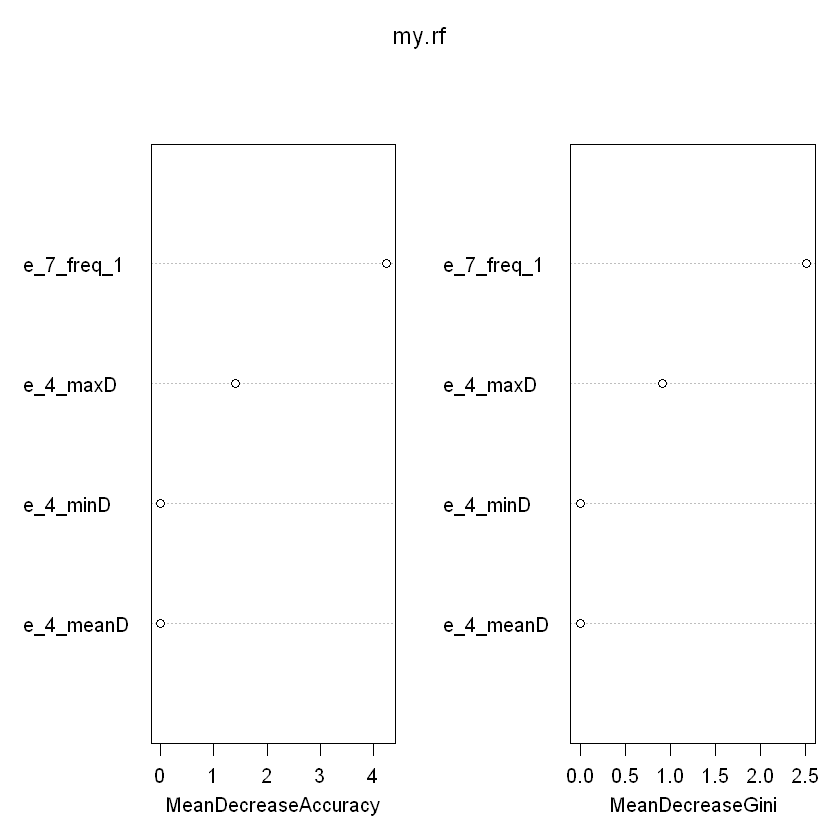

In [47]:
#Run Random Forest algorithm and print the results.

resultRF = eval(instances_df,test_instances_df,failure_incidents,TRUE)